In [1]:
from pathlib import Path
from scipy.stats import pearsonr
import numpy as np

import torch.nn as nn
import matplotlib.pyplot as plt

import uncertainties.uncertainties as unc
import dataloaders as dl
import models as m

import inspect
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

num=2000
batch_size = 200
test_num=2000
def entropy(x):
    return -x*np.log2(x) - (1-x)*np.log2(1-x)

def generate_mlp(input_size: int, cfg= None, initial_dropout=0.5, output_layer="softmax"):
    if cfg is None:
        cfg = [256, 512, 256, 2]
    layers = [
        nn.Flatten(),
        nn.Linear(input_size, cfg[0]),
        nn.ReLU(),
        nn.Dropout(initial_dropout)
    ]
    if len(cfg) > 1:
        for w1, w2 in zip(cfg[:-2], cfg[1:-1]):
            layers += [nn.Linear(w1, w2), nn.ReLU(),nn.Dropout(initial_dropout)]
    layers += [nn.Linear(cfg[-2], cfg[-1])]
    model = nn.Sequential(*layers)
    model.d = sum(cfg[i] * cfg[i + 1] for i in range(len(cfg) - 1))
    return model

import torch

class Conv1d(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 50, 4),
            nn.Conv1d(50, 100, 4),
            nn.MaxPool1d(4), #output size = 300
            nn.Flatten(),
            nn.Linear(300, 64),
            nn.LeakyReLU(),
            nn.Dropout(.5),
            nn.Linear(64, 64),
            nn.LeakyReLU(),
            nn.Dropout(.5),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Dropout(.5),
            nn.Linear(32, 2),
            )
    def forward(self, x):
        return self.model(x.view(x.size(0),1,-1))
conv1d_model = Conv1d()


# Definicja niepewności

In [8]:
num=2000
batch_size = 200
test_num=2000
def calculate(num, cfg):
    model = cfg if not isinstance(cfg, list) else generate_mlp(20, cfg)
    device='cuda:0'
    data_loader_train, data_loader_test, data_loader_train_r, data_loader_test_r = dl.get_dataloaders(num, batch_size)
    contextual_data_loader = dl.get_dataloaders_c(test_num, batch_size)

    classifier = m.Classifier(data_loader_train, data_loader_test, model, device)
    accuracies = classifier.train_and_eval()
    preds, gt = classifier.pred(contextual_data_loader)
    dropout_var, dropout_mean, dropout_raw_var = unc.get_preds_dropout(contextual_data_loader, classifier.model, device)
    laplace_var, laplace_mean = unc.get_preds_laplace(data_loader_train, contextual_data_loader, classifier.model, device)
    dists=[]
    for X, y in contextual_data_loader:
        dists.extend([dl.projection_distance(x.numpy()) for x in X])
    values = [preds, entropy(preds), laplace_mean, entropy(laplace_mean), dropout_mean, entropy(dropout_mean), laplace_var, dropout_var, dropout_raw_var]
    return np.mean(dropout_var), np.mean(laplace_var), np.mean(dropout_raw_var), accuracies, values, dists

In [9]:
results = [] 
cfgs = [[32,32,16,16,2], [64,32,16,2], [128,64,16,2], [128,32,16,2], [64,16,2], [32,16,2]]



cfgs = [conv1d_model, [128,64,16,2], [64,32,16,2], [64,16,2]]





for n in cfgs:
    r = map(lambda x: calculate(x, n), range(500, 30000, 500))
    results.append(list(r))
    print(f"skończyłem {n}")

Classifier learn has finished with acc: 0.512
Test acc: 0.464


ValueError: too many values to unpack (expected 3)

In [ ]:
plt.figure(figsize=(18, 16), dpi=80)
num=len(results)
for i in range(num):        
    ax1 = plt.subplot(num,1,i+1)
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    ax1.set_xlabel('Number of training data')
    ax1.set_ylabel('Accuracy')
    ax2.set_ylabel('Uncertainty')
    ax3.set_ylabel('Pearson correlation preds with distance')
    ax1.grid(False)
    ax2.grid(False)
    ax3.grid(False)
    ax3.spines.right.set_position(("axes", 1.15))
    #ax4 = ax1.twinx()
    #ax4.set_ylabel('Pearson correlation DO with distance')
    #ax4.spines.right.set_position(("axes", 1.25))

    ax1.plot(range(500, 30000, 500), [elem[3][1] for elem in results[i]], label = 'm' + str(i), linestyle='dotted')
    ax2.plot(range(500, 30000, 500), list(map(entropy, np.array(results, dtype=object)[i][:, 0]/100)), label = 'm' + str(i))
    ax2.legend(loc=4)
    ax3.plot(range(500, 30000, 500), [-pearsonr(a,b)[0] for a,b in zip([k[5] for k in results[i]], [k[4][-2] for k in results[i]])], label = 'm' + str(i), linestyle='dashdot')
    ax3.plot(range(500, 30000, 500), [pearsonr(a,b)[0] for a,b in zip([k[5] for k in results[i]], [k[4][0] for k in results[i]])],label = 'm' + str(i), linestyle='dashed')
#plt.set_title("Accuracy and Uncertainty vs number of training data in Dropout MCMC")

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,10))
ax2 = ax1.twinx()
ax1.set_xlabel('Number of training data')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Uncertainty')
for i in range(3):
    print(i)
    ax1.plot(range(2000, 20000, 500), [elem[3][0] for elem in results[i]], label = 'm' + str(i), linestyle='dotted')
    ax2.plot(range(2000, 20000, 500), np.array(results, dtype=object)[i][:, 1], label = 'm' + str(i))
ax2.legend(loc=4)
ax2.set_title("Accuracy and Uncertainty vs number of training data in Laplace")

In [ ]:
from scipy.stats import pearsonr
for i in range(5):
    print(pearsonr([elem[3][1] for elem in results[i]],
                   list(map(entropy, np.array(results, dtype=object)[i][:, 0]/100)))
         )

In [ ]:
plt.plot(list(map(entropy, np.array(results, dtype=object)[2][:, 0]/100)))

# Pojedyncza sieć - analiza

In [ ]:
def plot_histograms(arr, idx, arr2=None):
    if arr2 is None:
        fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10), sharex=True)
        ax1.hist(arr[idx])
        ax2.hist(arr)
    else:
        fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2,2, figsize=(10,10), sharex="col")
        ax1.hist(arr[idx])
        ax2.hist(arr)
        ax3.hist(arr2[idx])
        ax4.hist(arr2)

In [ ]:
def entropy_new(x):
    if x == 0:
        return 0
    elif x == 1:
        return 0
    else:
        return -x*np.log2(x) - (1-x)*np.log2(1-x)

In [9]:
num=5000
batch_size = 200
test_num=20000
model = generate_mlp(20, [128, 64,32,2])
#model = conv1d_model
device='cuda:0'
data_loader_train, data_loader_test, data_loader_train_r, data_loader_test_r = dl.get_dataloaders(num, batch_size)
contextual_data_loader = dl.get_dataloaders_c(test_num, batch_size)
#contextual_data_loader= data_loader_test
classifier = m.Classifier(data_loader_train, data_loader_test, model, device)
accuracies = classifier.train_and_eval()
preds, gt = classifier.pred(contextual_data_loader)
dropout_preds = unc.get_preds_dropout(contextual_data_loader, classifier.model, device)
laplace_preds = unc.get_preds_laplace(data_loader_train, contextual_data_loader, classifier.model, device)
dists=[]
for X, y in contextual_data_loader:
    dists.extend([dl.projection_distance(x.numpy()) for x in X])

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [10]:
next(iter(data_loader_test))[1]

tensor([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1])

In [51]:
dropout_uncertainties = unc.calculate_uncertainties(dropout_preds)[0]

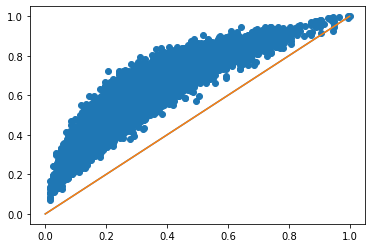

In [52]:
a = np.where(preds<0.5)[0]
plt.scatter(entropy(preds), entropy(np.mean(dropout_preds, axis=0)))
plt.scatter(entropy(preds)[a], entropy(np.mean(dropout_preds, axis=0))[a], color='r')

plt.plot([[0,0], [1,1]])

In [39]:
a = np.where(preds<0.5)[0]

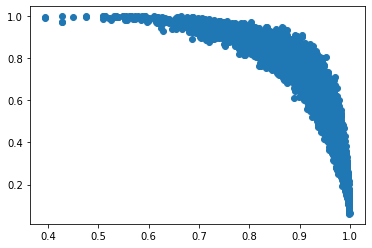

In [30]:
plt.scatter(preds, entropy(np.mean(dropout_preds, axis=0)))

(array([6.0000e+00, 8.0000e+00, 2.7000e+01, 4.7000e+01, 1.2100e+02,
        2.1300e+02, 5.0900e+02, 1.3570e+03, 5.8070e+03, 1.1905e+04]),
 array([0.39474627, 0.45521516, 0.515684  , 0.5761529 , 0.6366218 ,
        0.6970906 , 0.75755954, 0.8180284 , 0.87849724, 0.93896616,
        0.999435  ], dtype=float32),
 <BarContainer object of 10 artists>)

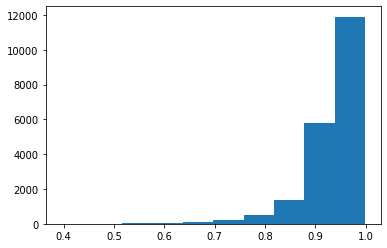

In [21]:
plt.hist(preds)

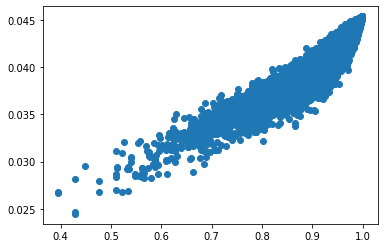

In [19]:
plt.scatter(preds, dropout_uncertainties['mutual_info'])

In [44]:
def analyse_uncertainties(x):
    laplace_uncertainties = unc.calculate_uncertainties(laplace_preds)[1]
    dropout_uncertainties = unc.calculate_uncertainties(dropout_preds)[1]
    
    fig, axs = plt.subplots(3,2, figsize=(10,15))
    print("Raw correlation ", pearsonr(preds, dists)[0])
    for i in range(3):
        print("Laplace: ", str(pearsonr(x, laplace_uncertainties[i])[0]))
        print("Dropout: ", str(pearsonr(x, dropout_uncertainties[i])[0]))
        axs[i, 0].scatter(x, laplace_uncertainties[i])
        axs[i, 1].scatter(x, dropout_uncertainties[i])
    
    for ax, col in zip(axs[0], ["Laplace", "Dropout"]):
        ax.set_title(col)
    for ax, row in zip(axs[:,0], ["Entropy", "Mutual_info", "Var_ratio"]):
        ax.set_ylabel(row, rotation=0, size='large')

Raw correlation  0.5563251586804489
Laplace:  0.5492693950688501
Dropout:  0.6486211088969807
Laplace:  0.08539993355088907
Dropout:  0.6204196405681157
Laplace:  0.008479461205332592
Dropout:  0.5377578362430073


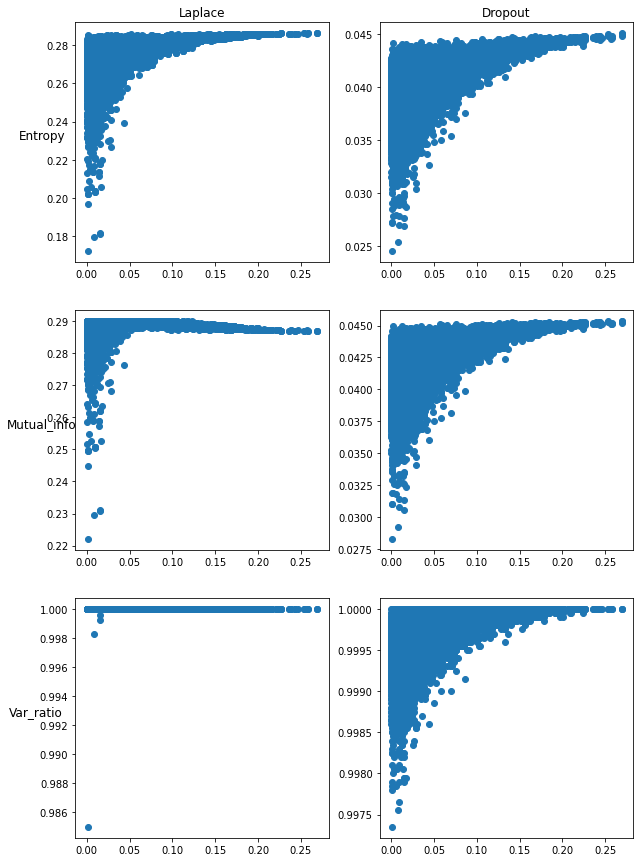

In [53]:
analyse_uncertainties(dists)

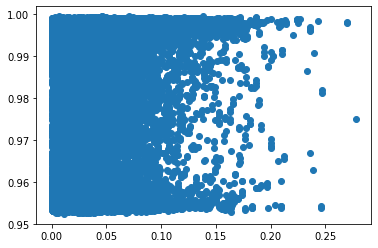

In [28]:
plt.scatter(dists, var_ratio)

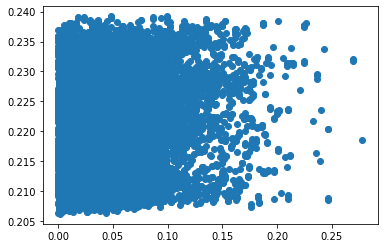

In [29]:
plt.scatter(dists, mutual_info)

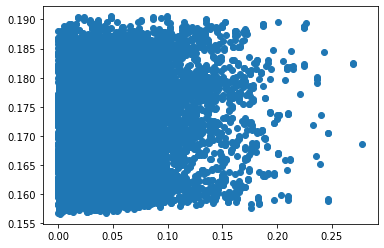

In [30]:
plt.scatter(dists, entropy)

In [ ]:
unc.calculate_uncertainties()

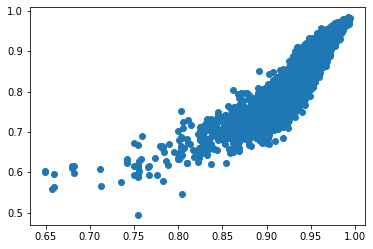

In [73]:
plt.scatter(preds, dropout_mean)

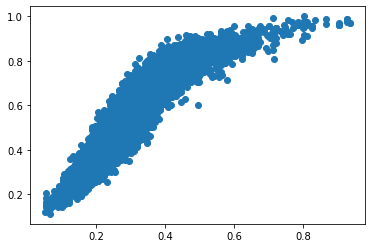

In [77]:
plt.scatter(entropy(preds), entropy(dropout_mean))

In [74]:
def a(po):
    print(pearsonr(dists, entropy(dropout_mean)))
    plt.scatter(dists, entropy(dropout_mean))

(-0.7554220697197883, 0.0)


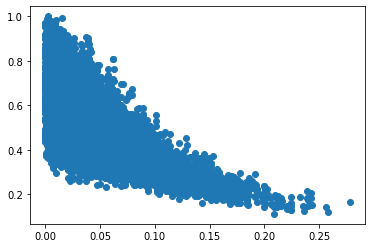

In [75]:
a(1)

(-0.727927737911342, 0.0)


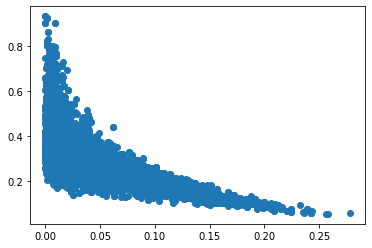

In [76]:
print(pearsonr(dists, entropy(preds)))
plt.scatter(dists, entropy(preds))

In [28]:
pearsonr(dists, entropy(dropout_mean))

(-0.6387495847124048, 0.0)

In [29]:
pearsonr(dists, entropy(preds))

(-0.559611281071095, 0.0)

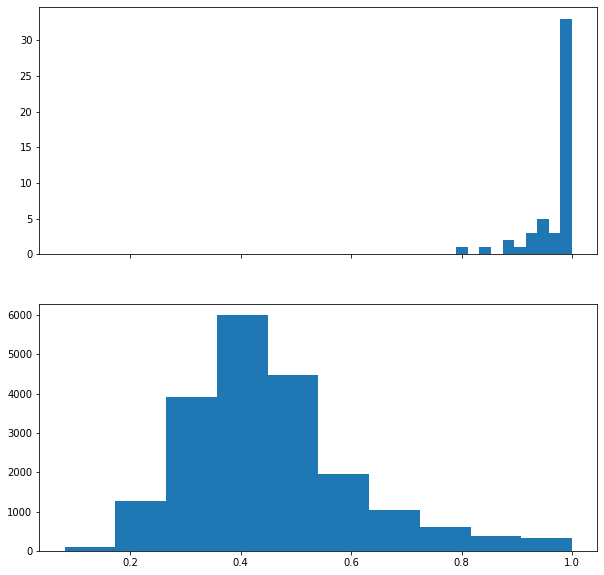

In [30]:
idx = np.where(preds<0.5)
plot_histograms(entropy(preds), idx)

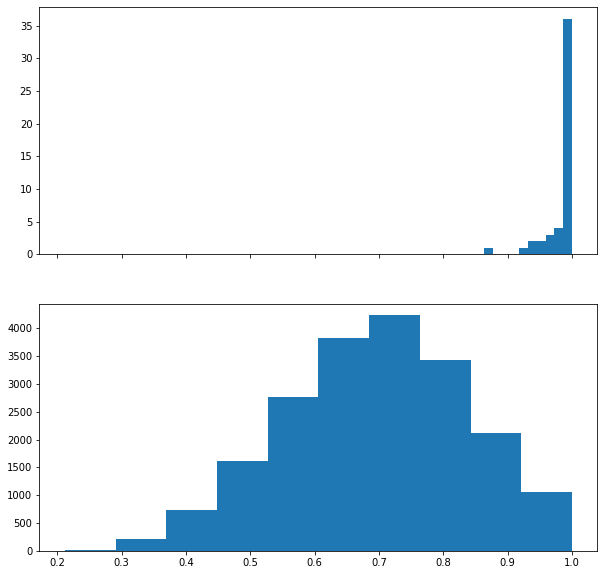

In [21]:
idx = np.where(preds<0.5)
plot_histograms(entropy(dropout_mean), idx)

(array([148.,  42.,  46.,  40.,  75.,  65.,  80., 101.,  63.,  90.]),
 array([-1.60171325e-15,  1.00000000e-01,  2.00000000e-01,  3.00000000e-01,
         4.00000000e-01,  5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
         8.00000000e-01,  9.00000000e-01,  1.00000000e+00]),
 <BarContainer object of 10 artists>)

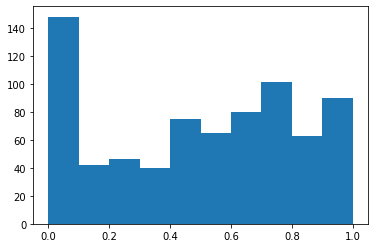

In [172]:
plt.hist(entropy(dropout_var/100))

(array([ 5., 12., 19., 24., 39., 47., 46., 31., 17., 10.]),
 array([0.12 , 0.179, 0.238, 0.297, 0.356, 0.415, 0.474, 0.533, 0.592,
        0.651, 0.71 ]),
 <BarContainer object of 10 artists>)

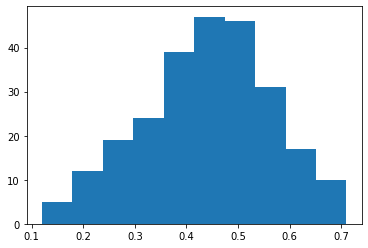

In [170]:
plt.hist(dropout_var/100)

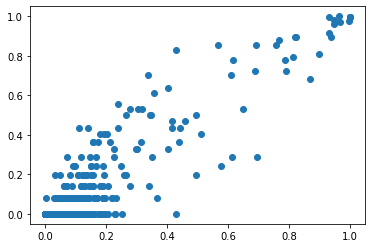

In [157]:
plt.scatter(entropy(preds),entropy(dropout_var/100))

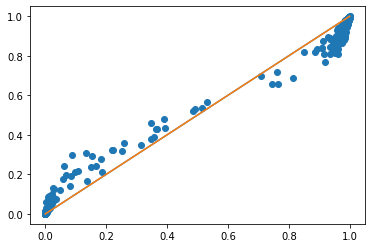

In [139]:
idx = np.where(np.logical_and(preds<0.5, gt == 1) | np.logical_and(preds>=0.5, gt == 0))[0]

plt.scatter(preds, dropout_mean)
plt.scatter(preds[idx], dropout_mean[idx], color='r')
plt.plot([[0,0],[1,1]])

In [141]:
preds

array([2.7208311e-05, 2.0564054e-03, 7.5344153e-04, ..., 9.9911898e-01,
       1.3883442e-07, 9.9137306e-01], dtype=float32)

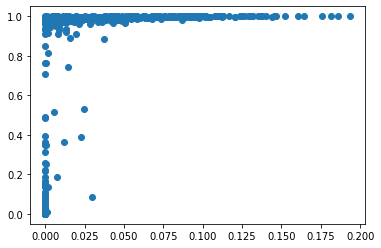

In [142]:
plt.scatter(dists, preds)

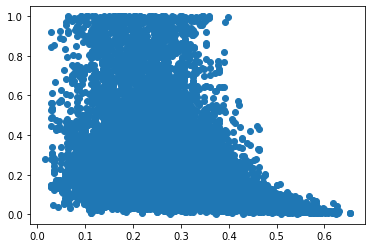

In [133]:
plt.scatter(np.power(dists, 1/3), entropy(dropout_mean))

In [119]:
dists

[0.14313663865234916,
 0.013359444510094593,
 0.03752087974310617,
 0.003441668541912705,
 0.05426332651492278,
 0.015274635436974679,
 0.01025093347477616,
 0.018320334089623597,
 0.033336465240691913,
 0.021331467293424042,
 0.04995751711823439,
 0.016336217599604325,
 0.02793600294732088,
 0.023054138173709545,
 0.03398119123061984,
 0.07884951215973178,
 0.04043448153097042,
 0.08521998276540967,
 0.0972163899291984,
 0.047688669642306024,
 0.0063700160999250344,
 0.03117613374653977,
 0.10554466306811829,
 0.049678494839118695,
 0.008705192521074644,
 0.012196494080386925,
 0.057608121867271954,
 0.02855388081907126,
 0.01151366593086563,
 0.021436478218464266,
 0.03659125918684814,
 0.023992354173041772,
 0.09146270414277591,
 0.10882741723982739,
 0.026283758644534312,
 0.0104028524131369,
 0.021515268508784713,
 0.023234981327144345,
 0.025657242300041377,
 0.005096250868106974,
 0.001713357885603199,
 0.06523254448181932,
 0.06596022167633192,
 0.0140071867418085,
 0.065206547

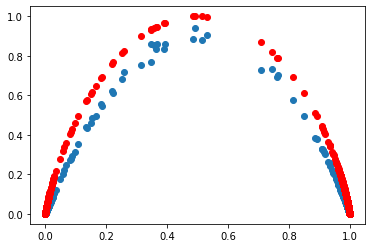

In [144]:
plt.scatter(preds, 20*laplace_var)
plt.scatter(preds, entropy(preds), color='r')
#plt.plot([[0,0],[1,1]])

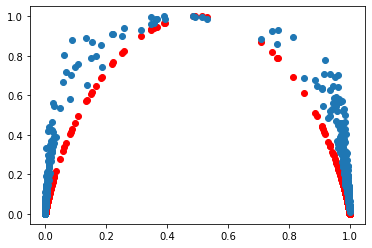

In [143]:
plt.scatter(preds, entropy(preds), color='red')
plt.scatter(preds, entropy(dropout_mean))

In [70]:
idx = np.where(np.logical_and(preds<0.5, gt == 1) | np.logical_and(preds>=0.5, gt == 0))[0]


In [107]:
idx = np.where(np.logical_and(preds<0.5, gt == 1))


In [108]:
idx

(array([], dtype=int64),)

In [63]:
preds

array([0.87398666, 0.1783883 , 0.54252815, ..., 0.07770262, 0.8734435 ,
       0.48616788], dtype=float32)

In [165]:
preds, gt = classifier.pred(data_loader_test)
dropout_var_test, dropout_mean, dropout_raw_var = unc.get_preds_dropout(data_loader_test, classifier.model, device)
laplace_var_test, laplace_mean = unc.get_preds_laplace(data_loader_train, data_loader_test, classifier.model, device)


In [49]:
gt = np.concatenate(gt)

In [50]:
a, b = classifier.pred(data_loader_test)

In [51]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.concatenate(b),np.round(a))

array([[1106,  154],
       [   1, 1239]])

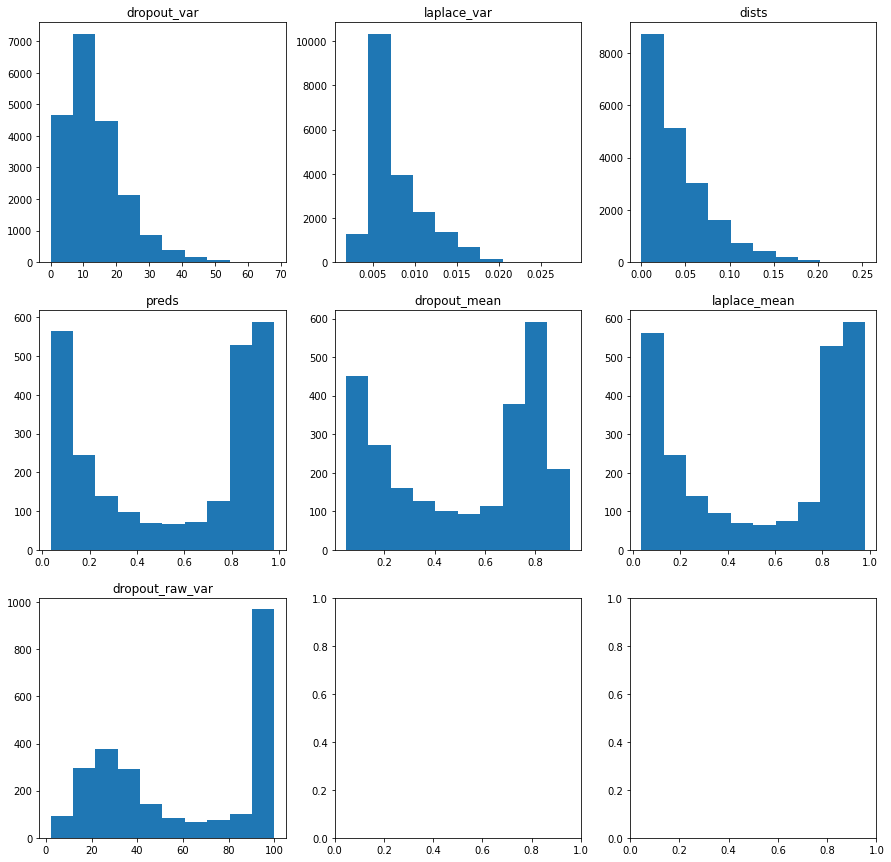

In [52]:
fig, axs = plt.subplots(3,3, figsize = (15,15))
for i, x in enumerate([dropout_var, laplace_var, dists, preds, dropout_mean, laplace_mean, dropout_raw_var]):
    axs[i//3, i%3].hist(x)
    axs[i//3, i%3].set_title(retrieve_name(x)[0])
    

## Niepewność błędnie zaklasyfikowanych

In [166]:
k = list(map(entropy_new, dropout_var_test/100))

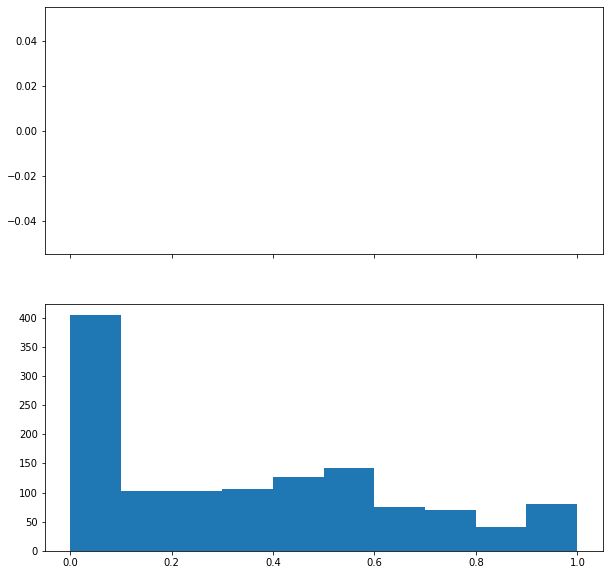

In [167]:
idx = np.where(np.logical_and(preds<0.5, gt == 1) | np.logical_and(preds>=0.5, gt == 0))[0]
plot_histograms(np.array(k), idx)

In [76]:
#P(HU)
print(len(np.where(np.array(k)> 0.8)[0])/20000)
#P(BD)
print(len(idx)/20000)

0.141

0.00035

In [79]:
0.00035/0.141

0.0024822695035460994

(array([1819.,    0.,    0.,  626.,    0.,    0.,  342.,    0.,  234.,
           0.,    0.,  169.,    0.,  134.,    0.,  106.,    0.,   88.,
           0.,   76.,    0.,   56.,   49.,    0.,   50.,   39.,    0.,
          41.,   22.,    0.,   31.,   19.,   18.,   17.,   20.,   15.,
          14.,    8.,   20.,   18.,   11.,    8.,   25.,    9.,   12.,
          18.,   29.,   16.,   42.,   56.]),
 array([0.08079314, 0.09917727, 0.11756141, 0.13594555, 0.15432969,
        0.17271382, 0.19109796, 0.2094821 , 0.22786623, 0.24625037,
        0.26463451, 0.28301865, 0.30140278, 0.31978692, 0.33817106,
        0.3565552 , 0.37493933, 0.39332347, 0.41170761, 0.43009174,
        0.44847588, 0.46686002, 0.48524416, 0.50362829, 0.52201243,
        0.54039657, 0.55878071, 0.57716484, 0.59554898, 0.61393312,
        0.63231725, 0.65070139, 0.66908553, 0.68746967, 0.7058538 ,
        0.72423794, 0.74262208, 0.76100622, 0.77939035, 0.79777449,
        0.81615863, 0.83454276, 0.8529269 , 0.87131104, 

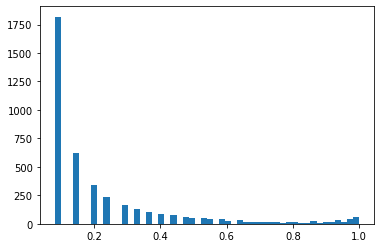

In [44]:
plt.hist(k, bins=50)

In [52]:
k

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.08079313589591118,
 0.557438185027989,
 0.08079313589591118,
 0,
 0.08079313589591118,
 0,
 0,
 0.28639695711595625,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.08079313589591118,
 0,
 0,
 0,
 0,
 0,
 0,
 0.6343095546405662,
 0,
 0,
 0,
 0,
 0,
 0,
 0.14144054254182067,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.08079313589591118,
 0,
 0.28639695711595625,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.4021791902022728,
 0,
 0,
 0.1943918578315762,
 0,
 0,
 0,
 0,
 0.14144054254182067,
 0,
 0,
 0.8687212463394045,
 0.14144054254182067,
 0,
 0,
 0,
 0,
 0,
 0,
 0.08079313589591118,
 0.1943918578315762,
 0,
 0,
 0.08079313589591118,
 0.08079313589591118,
 0,
 0.08079313589591118,
 0,
 0,
 0,
 0.499915958164528,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.08079313589591118,
 0.08079313589591118,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.08079313589591118,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.0807931358

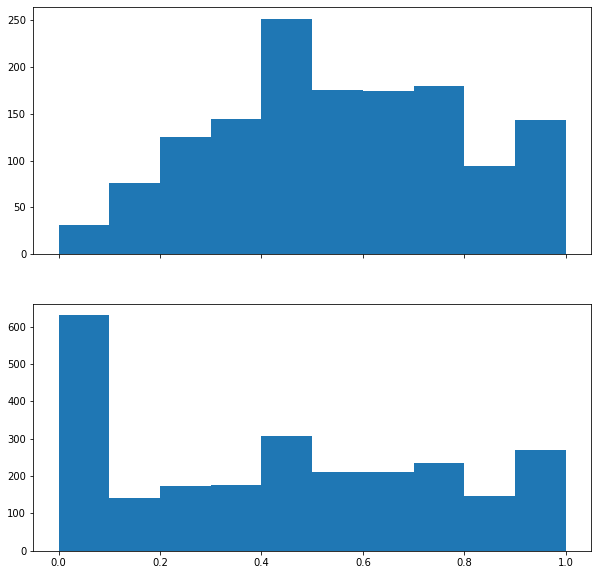

In [58]:
idx = np.where(preds>0.5)[0]
plot_histograms(np.array(k), idx)

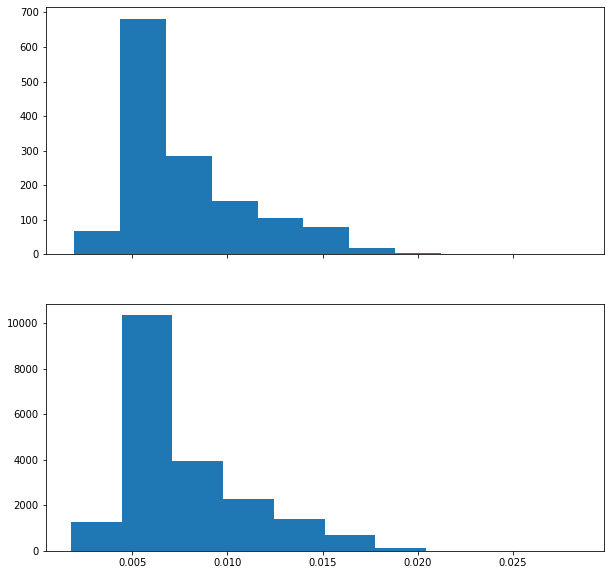

In [59]:
plot_histograms(laplace_var, idx)

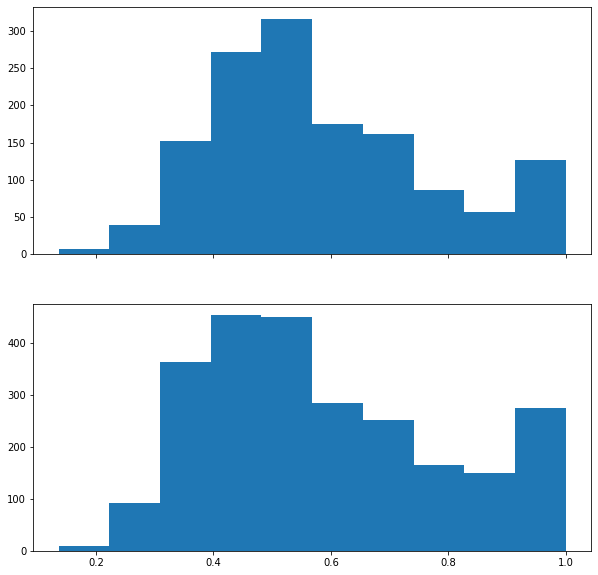

In [60]:
plot_histograms(entropy(preds), idx)

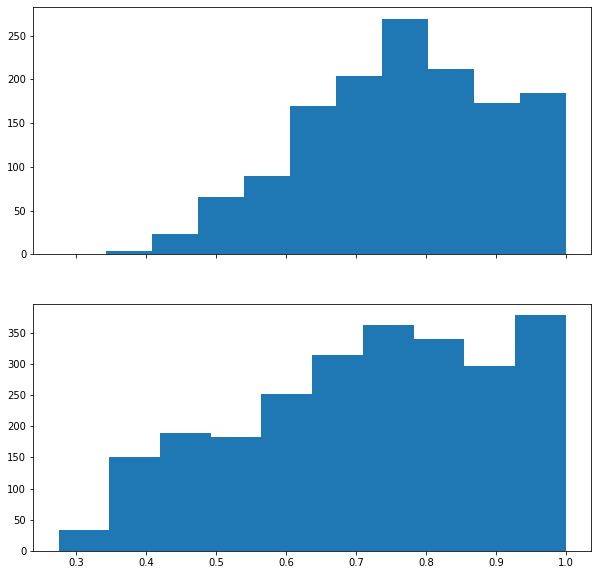

In [61]:
plot_histograms(entropy(dropout_mean), idx)

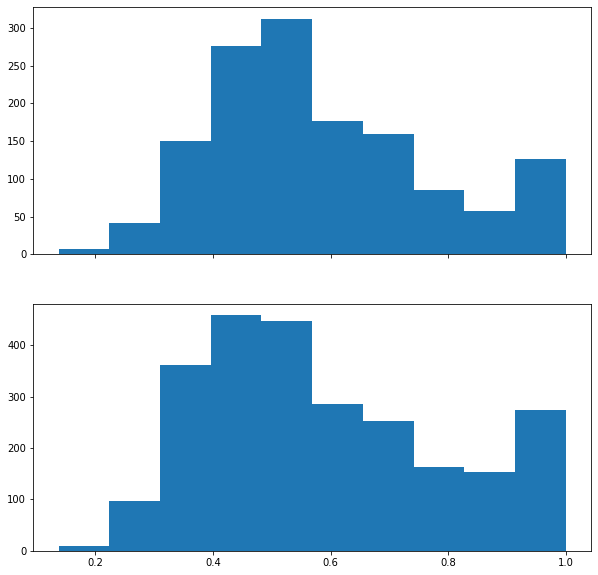

In [62]:
plot_histograms(entropy(laplace_mean), idx)

# Niepewność tak samo odległych

In [ ]:
plt.hist(dists)

In [ ]:
idx = np.where(np.abs(np.array(dists)-0.05) < 0.001)
plot_histograms(dropout_var, idx, preds)

In [ ]:
plot_histograms(laplace_var, idx, preds)

In [ ]:
plot_histograms(laplace_var, idx)

In [ ]:
plt.hist(dropout_var[np.where(preds>0.7)[0]])

In [ ]:
plt.hist(dropout_var)

In [ ]:
plt.hist(dists)

In [ ]:
idx = np.where(np.abs(np.array(dists)-0.05) < 0.001)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))
ax1.hist(dropout_var[idx])
ax2.hist(dropout_var)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(laplace_var[idx])
ax2.hist(laplace_var)

# Complexity measure

In [2]:
from math import pi
from scipy.special import logsumexp
import numpy as np


# This class is used to calculate the effective dimension of a model (classical or quantum)
# It implicitly computed the normalised Fisher information (which is called fhat) and then computes the eff dimension


class EffectiveDimension:
    def __init__(self, model, num_thetas, num_inputs):
        """
        Computes the effective dimension for a parameterised model.
        :param model: class instance
        :param num_thetas: int, number of parameter sets to include
        :param num_inputs: int, number of input samples to include
        """
        np.random.seed(0)
        self.model = model
        self.d = model.d
        self.num_thetas = num_thetas
        self.num_inputs = num_inputs
        # Stack data together and combine parameter sets to make calcs more efficient
        rep_range = np.tile(np.array([num_inputs]), num_thetas)
        params = np.random.uniform(self.model.thetamin, self.model.thetamax, size=(self.num_thetas, model.d))
        self.params = np.repeat(params, repeats=rep_range, axis=0)
        x = np.random.normal(0, 1, size=(self.num_inputs, self.model.inputsize))
        self.x = np.tile(x, (self.num_thetas, 1))

    def get_fhat(self):
        """
        :return: ndarray, f_hat values of size (num_inputs, d, d)
        """
        grads = self.model.get_gradient(params=self.params, x=self.x)  # get gradients, dp_theta
        output = self.model.forward(params=self.params, x=self.x)  # get model output
        fishers = self.model.get_fisher(gradients=grads, model_output=output)
        fisher_trace = np.trace(np.average(fishers, axis=0))  # compute the trace with all fishers
        # average the fishers over the num_inputs to get the empirical fishers
        fisher = np.average(np.reshape(fishers, (self.num_thetas, self.num_inputs, self.d, self.d)), axis=1)
        f_hat = self.d * fisher / fisher_trace  # calculate f_hats for all the empirical fishers
        return f_hat, fisher_trace

    def eff_dim(self, f_hat, n):
        """
        Compute the effective dimension.
        :param f_hat: ndarray
        :param n: list, used to represent number of data samples available as per the effective dimension calc
        :return: list, effective dimension for each n
        """
        effective_dim = []
        for ns in n:
            Fhat = f_hat * ns / (2 * pi * np.log(ns))
            one_plus_F = np.eye(self.d) + Fhat
            det = np.linalg.slogdet(one_plus_F)[1]  # log det because of overflow
            r = det / 2  # divide by 2 because of sqrt
            effective_dim.append(2 * (logsumexp(r) - np.log(self.num_thetas)) / np.log(ns / (2 * pi * np.log(ns))))
        return effective_dim

In [ ]:
ed_conv1d = EffectiveDimension(a, 100, 100)

In [19]:
a.thetamin = 0
a.thetamax = 1
b.thetamin = 0
b.thetamax = 1


In [ ]:
ad_b  = EffectiveDimension(a, 100, 100)